In [1]:
#  Required imports

print("Importing standard library")
import math, os, sys, time

print("Importing python data libraries")
import numpy as np
from matplotlib import cm, pyplot as plt
from   scipy import stats

print("Importing third party libraries")
import dill as pickle
import tensorflow as tf

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

from backends import plot as plot, density_model as density_model, VBFZ_analysis as VBFZ

Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


In [2]:
#  Inputs config

target_observable = "Dy_j_j"

cHWB_vals  = [0.0, -4.0, -2.0, 2.0, 4.0] 
cWtil_vals = [0.0, -0.4, -0.2, 0.2, 0.4]  

def get_input_fname (cHWB, cWtil) :
    cHWB_str  = f"{cHWB :.1f}".replace("-","m").replace(".","p")
    cWtil_str = f"{cWtil:.1f}".replace("-","m").replace(".","p")
    if (cHWB == 0) and (cWtil == 0) :
        return "../Data/SM_EWK_1M_rivet_output.pickle"
    if (cHWB == 0) :
        return f"../Data/cWtil_{cWtil_str}_full_400k_rivet_output.pickle"
    return f"../Data/cHWB_{cHWB_str}_cWtil_{cWtil_str}_full_200k_rivet_output.dat"


In [3]:
#  Model config

num_gaussians             = 30
max_epochs                = 1000
batch_size                = 1000
early_stopping_patience   = 4
early_stopping_min_delta  = 0
validation_split          = 0.3

white_linear_fraction_latent_space = 0.       # Keep 0, otherwise we get hard boundaries on latent space
whitening_num_points               = 200

learning_rate  = 2e-4        # 0.01 for SGD or 0.001 otherwise
optimiser      = "adam"      # SGD, Adam or AdaDelta
load_models    = False
load_whitening = False
save_plots     = True


In [4]:
#  Config variables dependent on chosen observable

obs_white_linear_fraction_data_space = {}
obs_white_linear_fraction_data_space ["Dphi_j_j"] = 0.8
obs_white_linear_fraction_data_space ["Dy_j_j"  ] = 0.8
obs_white_linear_fraction_data_space ["m_jj"    ] = 0.8
obs_white_linear_fraction_data_space ["m_ll"    ] = 0.8
obs_white_linear_fraction_data_space ["pT_j1"   ] = 0.8
obs_white_linear_fraction_data_space ["pT_j2"   ] = 0.8
obs_white_linear_fraction_data_space ["pT_jj"   ] = 0.8
obs_white_linear_fraction_data_space ["pT_ll"   ] = 0.9
obs_white_linear_fraction_data_space ["rap_jj"  ] = 0.8
obs_white_linear_fraction_data_space ["rap_ll"  ] = 0.8

white_linear_fraction_data_space = obs_white_linear_fraction_data_space[target_observable]


In [5]:

class whitening_method :
    def __init__ (self, func_form, alpha=0., beta=0., gamma=0., load_file=None, save_file=None, load_model_dir=None, save_model_dir=None) :
        assert func_form in ["step", "gaus"]
        self.func_form      = func_form
        self.alpha          = alpha
        self.beta           = beta
        self.gamma          = gamma
        self.load_file      = load_file
        self.save_file      = save_file
        self.load_model_dir = load_model_dir
        self.save_model_dir = save_model_dir

whitening_gaus = whitening_method("gaus",          load_file=f".white_funcs_paper_gaus_{target_observable}.pickle", save_file=f".white_funcs_paper_gaus_{target_observable}.pickle", load_model_dir=f".EWK_density_model_paper_gaus_{target_observable}", save_model_dir=f".EWK_density_model_paper_gaus_{target_observable}")
whitening_step = whitening_method("step", 4, 3, 1, load_file=f".white_funcs_paper_step_{target_observable}.pickle", save_file=f".white_funcs_paper_step_{target_observable}.pickle", load_model_dir=f".EWK_density_model_paper_step_{target_observable}", save_model_dir=f".EWK_density_model_paper_step_{target_observable}")
whitening_methods = [whitening_step]


In [6]:
#  Configure VBFZ observables

remove_observables =  [obs for obs in VBFZ.all_observables if obs != target_observable] 
VBFZ.configure(remove_observables)
print(f"Configured with {VBFZ.num_observables} observables: " + ", ".join(VBFZ.observables))


Configured with 1 observables: Dy_j_j


In [7]:
#  Plots config

intervals       = []
minor_intervals = []
x_prime         = 0.

if target_observable is "pT_ll" :
    intervals       = []
    minor_intervals = []
    x_prime         = 500
    
if target_observable is "Dphi_j_j" :
    intervals       = [[-np.pi, r"$-\pi$"], [-3.*np.pi/4., r"$-\frac{3\pi}{4}$"], [-np.pi/2., r"$-\frac{\pi}{2}$"],
                       [-np.pi/4., r"$-\frac{\pi}{4}$"], [0, "$0$"], [np.pi/4., r"$\frac{\pi}{4}$"],
                       [np.pi/2., r"$\frac{\pi}{2}$"], [3.*np.pi/4., r"$\frac{3\pi}{4}$"], [np.pi, r"$\pi$"]]
    minor_intervals = [(i-16.)*np.pi/16. for i in range(32) if i % 4 != 0]
    x_prime         = 0.8

if target_observable is "m_jj" :
    intervals       = []
    minor_intervals = []
    x_prime         = 2500

if target_observable is "Dy_j_j" :
    intervals       = []
    minor_intervals = []
    x_prime         = 4.


In [8]:
#  Load and format the data
#

data_tables = {}
for cHWB in cHWB_vals :
    for cWtil in cWtil_vals :
        input_fname = get_input_fname (cHWB, cWtil)
        data_tables [(cHWB, cWtil)] = VBFZ.load_table(input_fname, transform=True)


Loading events from file ../Data/SM_EWK_1M_rivet_output.pickle
 -- Table created with 1000000 events
 -- filtering observable m_ll between 75 and 105
 -- 660799 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 660766 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 660766 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 652255 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 643177 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 643177 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 643177 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 643177 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 643054 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 641867 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 641867 events survived
 -- filtering observ

 -- Table created with 400000 events
 -- filtering observable m_ll between 75 and 105
 -- 264930 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 264832 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 264832 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 261459 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 257800 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 257799 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 257799 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 257799 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 257741 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 257251 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 257251 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 

 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 130039 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 130015 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 130015 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 128315 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 126328 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 126328 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 126328 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 126328 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 126308 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 126074 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 126074 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 

 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 131734 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 131717 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 131717 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 129964 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 128121 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 128121 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 128121 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 128121 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 128100 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 127852 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 127852 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 

 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 132875 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 132825 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 132825 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 131078 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 129267 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 129267 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 129267 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 129267 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 129242 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 129021 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 129021 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 

 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 132752 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 132746 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 132746 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 131057 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 129315 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 129315 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 129315 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 129315 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 129290 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 129048 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 129048 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 

 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 132583 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 132543 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 132543 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 130801 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 128962 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 128962 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 128962 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 128962 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 128933 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 128695 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 128695 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 

In [9]:

for white_meth in whitening_methods :
    
    whitening_funcs = None
    if (load_whitening) and (type(white_meth.load_file) != type(None) and (os.path.isfile(white_meth.load_file))) :
        print(f"Loading whitening functions from file {white_meth.load_file}")
        whitening_funcs = pickle.load(open(white_meth.load_file, "rb"))

    axis_configs = [[VBFZ.transformed_observable_limits[target_observable][0], VBFZ.transformed_observable_limits[target_observable][1], whitening_num_points,  white_linear_fraction_data_space, white_linear_fraction_latent_space]]

    white_meth.physical_data, white_meth.weights, white_meth.white_data = {}, {}, {}
    for cHWB in cHWB_vals :
        for cWtil in cWtil_vals :
            data = data_tables [(cHWB, cWtil)]
            #  Seperate data from weights
            white_meth.physical_data [(cHWB, cWtil)], white_meth.weights [(cHWB, cWtil)] = data.get_observables_and_weights()
            #  Whiten data
            print(f"Whitening dataset for {(cHWB, cWtil)}")
            white_meth.white_data[(cHWB, cWtil)], whitening_funcs = whiten_axes (data.data, data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=data.get_weights(), 
                                                                                 func_form=white_meth.func_form, alpha=white_meth.alpha, beta=white_meth.beta, gamma=white_meth.gamma)
            
    if len(intervals) > 0 :
        white_meth.white_intervals = whiten_axes (np.array([[i[0]] for i in intervals]), data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=[1 for i in intervals], 
                                                  func_form=white_meth.func_form, alpha=white_meth.alpha, beta=white_meth.beta, gamma=white_meth.gamma)[0]
    else : white_meth.white_intervals = []
    
    if len(minor_intervals) > 0 :
        white_meth.white_minor_intervals = whiten_axes (np.array([[i] for i in minor_intervals]), data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=[1 for i in minor_intervals], 
                                                        func_form=white_meth.func_form, alpha=white_meth.alpha, beta=white_meth.beta, gamma=white_meth.gamma)[0]
    else : white_meth.white_minor_intervals = []
    
    if type(white_meth.save_file) != type(None) :
        print(f"Saving whitening functions to file {white_meth.save_file}")
        pickle.dump(whitening_funcs, open(white_meth.save_file, "wb"))
        

Whitening dataset for (0.0, 0.0)
Whitening dataset for (0.0, -0.4)
Whitening dataset for (0.0, -0.2)
Whitening dataset for (0.0, 0.2)
Whitening dataset for (0.0, 0.4)
Whitening dataset for (-4.0, 0.0)
Whitening dataset for (-4.0, -0.4)
Whitening dataset for (-4.0, -0.2)
Whitening dataset for (-4.0, 0.2)
Whitening dataset for (-4.0, 0.4)
Whitening dataset for (-2.0, 0.0)
Whitening dataset for (-2.0, -0.4)
Whitening dataset for (-2.0, -0.2)
Whitening dataset for (-2.0, 0.2)
Whitening dataset for (-2.0, 0.4)
Whitening dataset for (2.0, 0.0)
Whitening dataset for (2.0, -0.4)
Whitening dataset for (2.0, -0.2)
Whitening dataset for (2.0, 0.2)
Whitening dataset for (2.0, 0.4)
Whitening dataset for (4.0, 0.0)
Whitening dataset for (4.0, -0.4)
Whitening dataset for (4.0, -0.2)
Whitening dataset for (4.0, 0.2)
Whitening dataset for (4.0, 0.4)
Saving whitening functions to file .white_funcs_paper_step_Dy_j_j.pickle


In [10]:
#  Weight all training points equally
#

for white_meth in whitening_methods :
    white_meth.weights_to_fit_v1 = {k:i/np.sum(i) for k,i in white_meth.weights.items()}
    cHWB_sf, cWtil_sf = np.max(np.fabs(cHWB_vals)), np.max(np.fabs(cWtil_vals))
    cHWB_sf, cWtil_sf = 1./cHWB_sf if (cHWB_sf>0) else 1., 1./cWtil_sf if (cWtil_sf>0) else 1.
    white_meth.weights_to_fit_v2 = {k:(1+np.fabs(k[0])*cHWB_sf)*(1+np.fabs(k[1])*cWtil_sf)*i/np.sum(i) for k,i in white_meth.weights_to_fit_v1.items()}
    

In [11]:
#  Save numbers required to plot whitening function
#

for white_meth in whitening_methods :

    alpha, beta , gamma      = white_meth.alpha, white_meth.beta, white_meth.gamma
    axmin, axmax, ax_npoints = VBFZ.transformed_observable_limits[target_observable][0], VBFZ.transformed_observable_limits[target_observable][1], whitening_num_points
    ax_scan_points           = np.linspace(axmin, axmax, 1+ax_npoints)
    data_frac_constant       = white_linear_fraction_data_space
    gauss_frac_constant      = white_linear_fraction_latent_space
    dataset   = white_meth.physical_data[(0.,0.)][:,0]
    weights   = white_meth.weights      [(0.,0.)]
    ds_and_w  = np.array([(x,w) for x, w in zip(dataset, weights) if (x>axmin and x<axmax)])
    dataset, weights = [x[0] for x in ds_and_w], [x[1] for x in ds_and_w]
    weights   = weights / np.sum(weights)
    func_form = white_meth.func_form
        
    print("Getting data c.d.f.")
    data_cdf = []
    for A in ax_scan_points :
        sys.stdout.write(f"\rScan point is: {A:.4f}  ----------")
        data_cdf.append(np.sum([w for x,w in zip(dataset, weights) if x < A]))
    data_cdf     = np.array(data_cdf)
    constant_cdf = (ax_scan_points - axmin) / (axmax - axmin)
    combined_cdf = data_frac_constant*constant_cdf + (1-data_frac_constant)*data_cdf
    
    white_meth.ax_scan_points = ax_scan_points
    white_meth.cdf_data, white_meth.cdf_data_linear, white_meth.cdf_x = data_cdf, constant_cdf, combined_cdf

    print("\nGetting latent c.d.f.")
    if func_form == "step" :
        white_space_x   = np.linspace(-5, 5, 201)
        Smooth_step_y   = 1. / (1 + np.exp((white_space_x-beta)*alpha-gamma)) / (1 + np.exp(-(white_space_x+beta)*alpha-gamma))
        white_meth.white_space_y = Smooth_step_y
        Smooth_step_cdf = np.array([np.sum(Smooth_step_y[:i+1]) for i in range(len(Smooth_step_y))])
        Smooth_step_cdf = Smooth_step_cdf / Smooth_step_cdf[-1]
        Smooth_step_cdf[0] = 0.
        constant_cdf    = (white_space_x + 5.) / 10.
        white_space_cdf = gauss_frac_constant*constant_cdf + (1-gauss_frac_constant)*Smooth_step_cdf
        white_meth.cdf_target    = Smooth_step_cdf
        white_meth.white_space_x = white_space_x
    else :
        white_space_x   = np.linspace(-5, 5, 201)
        white_meth.white_space_y = stats.norm.pdf(white_space_x)
        Gauss_cdf       = stats.norm.cdf(white_space_x)
        Gauss_cdf[0], Gauss_cdf[-1] = 0., 1.
        constant_cdf    = (white_space_x + 5.) / 10.
        white_space_cdf = gauss_frac_constant*constant_cdf + (1-gauss_frac_constant)*Gauss_cdf 
        white_meth.cdf_target    = Gauss_cdf
        white_meth.white_space_x = white_space_x
        
    white_meth.white_space_x = white_space_x
    white_meth.cdf_latent_linear, white_meth.cdf_u = constant_cdf, white_space_cdf
    
    print("Done")


Getting data c.d.f.
Scan point is: 1.5000  ----------
Getting latent c.d.f.
Done


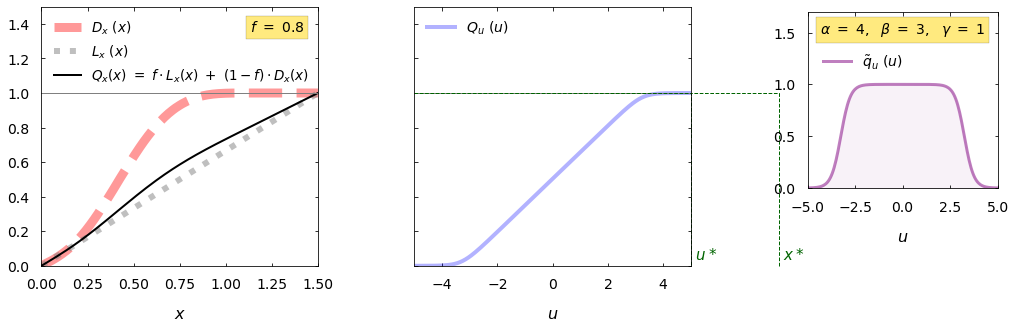

In [12]:
#  Plot whitening functions
#

for white_meth in whitening_methods :
    y_prime = np.interp(x_prime, white_meth.ax_scan_points, white_meth.cdf_x        )
    u_prime = np.interp(y_prime, white_meth.cdf_u         , white_meth.white_space_x)
    
    fig    = plt.figure(figsize=(14., 0.8*4.5))
    ax     = fig.add_axes([0.01, 0.01, 0.32*12./14., 1.])
    plot_x = white_meth.ax_scan_points
    ax.plot(plot_x, white_meth.cdf_data        , "-", linestyle="--", lw=9, c="r"   , alpha=0.4, label="$D_x~(x)$")
    ax.plot(plot_x, white_meth.cdf_data_linear , "-", linestyle=":" , lw=6, c="grey", alpha=0.5, label="$L_x~(x)$")
    ax.plot(plot_x, white_meth.cdf_x           , "-", linestyle="-" , lw=2, c="k"   , label="$Q_x(x) ~=~ f\cdot L_x(x) ~+~ (1-f)\cdot D_x(x)$")
    ax.axhline(1, linestyle="-", color="grey", linewidth=1)
    ax.set_xlim([plot_x[0], plot_x[-1]])
    ax.set_ylim([0        , 1.5])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
    ax.set_xlabel("$x$"   , fontsize=16, labelpad=15)
    ax.legend(loc="upper left", fontsize=13.5, frameon=False)
    ax.plot([x_prime, x_prime, 2*plot_x[-1]-plot_x[0]], [0, y_prime, y_prime], "--", c="darkgreen", lw=1, clip_on=False)
    ax.text(x_prime, 0.02, " $x*$", ha="left", va="bottom", fontsize=15, c="darkgreen")
    ax.text(0.95, 0.95, f"$f~=~{white_linear_fraction_data_space:.1f}$", ha="right", va="top", fontsize=14, transform=ax.transAxes, bbox=dict(facecolor="gold", alpha=0.5, linewidth=0.3))
    
    ax     = fig.add_axes([0.38, 0.01, 0.32*12./14., 1.])
    plot_x = white_meth.white_space_x
    ax.plot(plot_x, white_meth.cdf_u, "-", linestyle="-" , lw=4, c="b", label="$Q_u~(u)$", alpha=0.3)
    ax.axhline(1, linestyle="-", color="grey", linewidth=1)
    ax.set_xlim([plot_x[0], plot_x[-1]])
    ax.set_ylim([0        , 1.5])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
    ax.get_yaxis().set_ticklabels([])
    ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
    ax.legend(loc="upper left", fontsize=14, frameon=False)
    ax.plot([plot_x[0], u_prime, u_prime], [y_prime, y_prime, 0], "--", c="darkgreen", lw=1, clip_on=False)
    ax.text(u_prime, 0.02, " $u*$", ha="left", va="bottom", fontsize=15, c="darkgreen")
    
    ax     = fig.add_axes([0.77, 0.31, 0.22*12./14., 0.68])
    ax.plot(white_meth.white_space_x, white_meth.white_space_y, "-", linestyle="-", lw=3, c="purple", label=r"${\tilde q}_u~(u)$", alpha=0.5)
    ax.fill_between(white_space_x, np.zeros(shape=white_meth.white_space_x.shape), white_meth.white_space_y, color="purple", alpha=0.05)
    ax.set_xlim([white_space_x[0], white_space_x[-1]])
    maxy = 1.7*np.max(white_meth.white_space_y)
    ax.set_ylim([0        , maxy])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
    ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
    ax.legend(loc=(0.05, 0.63), fontsize=14, frameon=False) 
    ax.text(0.5, 0.95, r"$\alpha~="+f"~{white_meth.alpha:.0f}"+r",~~\beta ~="+f"~{white_meth.beta :.0f}"+r",~~\gamma~="+f"~{white_meth.gamma:.0f}$", ha="center", va="top", fontsize=14, transform=ax.transAxes, bbox=dict(facecolor="gold", alpha=0.5, linewidth=0.3))
    
    plt.subplots_adjust(wspace=0.2, left=0.01, right=0.99)
    if save_plots :
        plt.savefig(f"figures/paper0D_model/projection_functions_{target_observable}.pdf", bbox_inches="tight")
    plt.show()

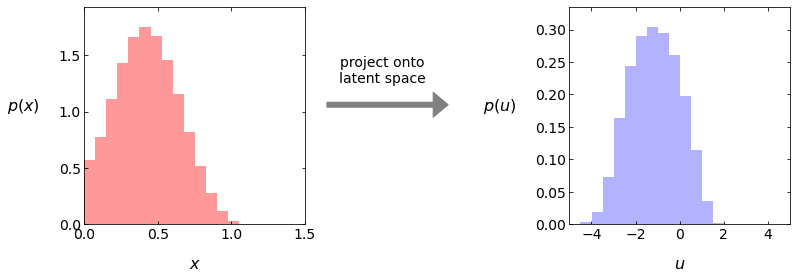

In [13]:
#  Weight all training points equally
#  -  and plot original / laten distributions
#

for white_meth in whitening_methods :
    fig = plt.figure(figsize=(10, 4))

    ax   = fig.add_subplot(1, 2, 1)
    bins = np.linspace(VBFZ.transformed_observable_limits[target_observable][0], VBFZ.transformed_observable_limits[target_observable][1], 21)
    vals, _, _ = ax.hist(white_meth.physical_data[(0,0)], weights=white_meth.weights[(0,0)], bins=bins, density=True, color="r", alpha=0.4)
    hmax = 1.1 * np.max(vals)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim([0      , hmax])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
    ax.set_ylabel("$p(x)$", fontsize=16, labelpad=35, rotation=0)
    ax.set_xlabel("$x$"   , fontsize=16, labelpad=15)
    
    for idx, i in enumerate(intervals) :
        lw = 2.+2*np.fabs(math.floor(len(intervals)/2.)-idx)/len(intervals)
        ax.axvline(i[0], linestyle="--", c="grey", linewidth=lw)
        ax.text(i[0], 1.1*hmax, i[1], c="grey", fontsize=12, ha="center")
        ax.plot([i[0], i[0]], [hmax, 1.05*hmax], linestyle="--", c="grey", linewidth=lw, clip_on=False)
    
    for i in minor_intervals :
        ax.axvline(i, linestyle=":", c="grey", linewidth=1.)
        
    ax   = fig.add_subplot(1, 2, 2)
    edge = np.max(np.fabs(white_meth.white_data[(0,0)]))
    bins = np.linspace(-edge, edge, 21)
    vals , _, _ = ax.hist(white_meth.white_data[(0,0)], weights=white_meth.weights[(0,0)], bins=bins, density=True, color="b", alpha=0.3)
    hmax = 1.1 * np.max(vals)
    ax.set_xlim([np.min(np.concatenate([bins, [i[0] for i in white_meth.white_intervals]])), np.max(np.concatenate([bins, [i[0] for i in white_meth.white_intervals]]))])
    ax.set_ylim([0      , hmax])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
    ax.set_ylabel("$p(u)$", fontsize=16, labelpad=35, rotation=0)
    ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
    
    for idx, (i, wi) in enumerate(zip(intervals, white_meth.white_intervals)) :
        lw = 2.+2*np.fabs(math.floor(len(intervals)/2.)-idx)/len(intervals)
        ax.axvline(wi[0], linestyle="--", c="grey", linewidth=lw)
        xlo, xhi, xrange = bins[0], bins[-1], bins[-1] - bins[0]
        label_pos        = xlo + xrange*(idx/(len(intervals)-1.)), 1.1*hmax, 1.05*hmax
        line_pos         = wi[0], hmax
        ax.text(label_pos[0], label_pos[1], i[1], c="grey", fontsize=12, ha="center")
        ax.plot([line_pos[0], label_pos[0]], [line_pos[1], label_pos[2]], linestyle="--", c="grey", linewidth=lw, clip_on=False)
        
    for wi in white_meth.white_minor_intervals :
        ax.axvline(wi, linestyle=":", c="grey", linewidth=1.)
        
    ax.text(-0.85, 0.65, "project onto\nlatent space", transform=ax.transAxes, ha="center", fontsize=14)
    
    ax.annotate("", xy=(-0.55, 0.55), xycoords  ="axes fraction",
                xytext=(-1.1 , 0.55), textcoords="axes fraction",
                arrowprops=dict(width=5, headwidth=25, headlength=15, facecolor="grey", edgecolor="grey"))
    
    plt.subplots_adjust(wspace=1.2, left=0.01, right=0.99)
    if save_plots :
        plt.savefig(f"figures/paper0D_model/projection_distributions_{target_observable}.pdf", bbox_inches="tight")
    plt.show()
    

In [14]:
#  Plotting mixture of Gaussians, since it was observed that -ve deviations around SM are hard to model
#       if the distribution is dominated by a single Gaussian mode

def plot_mixture_model (savefig=None, log=False) :

    colours   = cm.get_cmap('brg', num_gaussians)   # 'hsv'
    newcolors = colours(np.linspace(0, 1, num_gaussians))
    x         = np.linspace(-6, 6, 241)
    bins      = np.linspace(-6, 6, 61)

    for white_meth in whitening_methods :

        fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

        density_model = white_meth.density_model

        params = density_model.likelihood_models[0].get_gauss_params([[0,0]])[0]
        fracs  = params[:num_gaussians]
        means  = params[num_gaussians:2*num_gaussians]
        sigmas = params[2*num_gaussians:3*num_gaussians]

        ds, weights = white_meth.white_data[(0,0)][:,0], white_meth.weights_to_fit_v2[(0,0)]

        y1, int1 = 0., 0.
        bin_entries , _  = np.histogram(ds, weights=weights, bins=bins)
        bin_variance, _  = np.histogram(ds, weights=weights*weights, bins=bins)
        frac_errors      = np.sqrt(bin_variance) / bin_entries
        hvals1, _, _     = ax0.hist(ds, weights=weights, density=True, color="darkgrey", alpha=0.5, bins=bins, label=r"MG5 events ($c_{HWB}=0,~{\tilde c}_W=0$)")
        for i in range(num_gaussians) :
            yp   = fracs[i]*stats.norm.pdf(x, means[i], sigmas[i])
            y1   = y1 + yp
            int1 = int1 + np.array([fracs[i]*(stats.norm.cdf(bins[j+1], means[i], sigmas[i])-stats.norm.cdf(bins[j], means[i], sigmas[i]))/(bins[j+1]-bins[j]) for j in range(len(bins)-1)])
            ax0.plot(x, yp, c=newcolors[i], linewidth=1, linestyle="--")
        ax0.plot(x, y1, c="k", linewidth=3, linestyle="--", label=r"$p_\phi~(~u~|~c_{HWB}=0,~{\tilde c}_W=0~)$")

        ax0.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax0.set_ylabel("$p(u)$", fontsize=16, labelpad=45, rotation=0)
        ax0.legend(loc="upper left", frameon=False, fontsize=14)

        rat_x, rat_y, rat_ey = [], [], []
        for idx, b in enumerate(bins) :
            rat_x.append(b)
            if (idx==0) or (idx==len(bins)-1) : continue
            rat_x.append(b)
        for y, ey in zip(hvals1/int1 - 1, frac_errors*hvals1/int1) :
            rat_y .append(y )
            rat_y .append(y )
            rat_ey.append(ey)
            rat_ey.append(ey)
        rat_x, rat_y, rat_ey = np.array(rat_x), np.array(rat_y), np.array(rat_ey)

        ax2.axhline(0, linestyle="--", c="k", linewidth=3)
        ax2.axhline(-0.10, linestyle=":" , c="grey", linewidth=1)
        ax2.axhline(-0.05, linestyle=":" , c="grey", linewidth=1)
        ax2.axhline(0.05 , linestyle=":" , c="grey", linewidth=1)
        ax2.axhline(0.10 , linestyle=":" , c="grey", linewidth=1)
        ax2.set_yticks([-0.1, 0, 0.1])
        ax2.yaxis.set_ticklabels(["$-10\%$", "$0$", "$+10\%$"])
        ax2.plot(rat_x, rat_y, "-", c="darkgrey")
        ax2.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="darkgrey", alpha=0.5)
        ax2.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax2.set_xlabel("$u$"   , fontsize=18, labelpad=15)
        ax2.set_ylabel(r"$\frac{p(u)~-~p_\phi(u)}{p_\phi(u)}$", fontsize=21, labelpad=70, rotation=0)
        ax2.set_ylim  ([-0.15, 0.15])

        params = density_model.likelihood_models[0].get_gauss_params([(0,0.4)])[0]
        fracs  = params[:num_gaussians]
        means  = params[num_gaussians:2*num_gaussians]
        sigmas = params[2*num_gaussians:3*num_gaussians]

        ds, weights = white_meth.white_data[(0.0,0.4)][:,0], white_meth.weights_to_fit_v2[(0.0,0.4)]
        
        y2, int2 = 0., 0.
        bin_entries , _  = np.histogram(ds, weights=weights, bins=bins)
        bin_variance, _  = np.histogram(ds, weights=weights*weights, bins=bins)
        frac_errors      = np.sqrt(bin_variance) / bin_entries
        hvals2, _, _     = ax1.hist(ds, weights=weights, density=True, color="darkgrey", alpha=0.5, bins=bins, label=r"MG5 events ($c_{HWB}=0,~{\tilde c}_W=0.4$)")
        for i in range(num_gaussians) :
            yp   = fracs[i]*stats.norm.pdf(x, means[i], sigmas[i])
            y2   = y2 + yp
            int2 = int2 + np.array([fracs[i]*(stats.norm.cdf(bins[j+1], means[i], sigmas[i])-stats.norm.cdf(bins[j], means[i], sigmas[i]))/(bins[j+1]-bins[j]) for j in range(len(bins)-1)])
            ax1.plot(x, yp, c=newcolors[i], linewidth=1, linestyle="--")
        ax1.plot(x, y1, c="k"   , linewidth=3, linestyle="--")
        ax1.plot(x, y2, c="grey", linewidth=3, linestyle="--", label=r"$p_\phi~(~u~|~c_{HWB}=0,~{\tilde c}_W=0.4~)$")

        ax1.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax1.legend(loc="upper left", frameon=False, fontsize=14)

        rat_y2, rat_ey2, rat_1_over_2, rat_data = [], [], [], []
        for y, ey, f, f_data in zip(hvals2/int2 - 1, frac_errors*hvals2/int2, int1/int2 - 1, hvals1/hvals2 - 1) :
            rat_y2      .append(y )
            rat_y2      .append(y )
            rat_ey2     .append(ey)
            rat_ey2     .append(ey)
            rat_1_over_2.append(f )
            rat_1_over_2.append(f )
            rat_data    .append(f_data)
            rat_data    .append(f_data)
        rat_y2, rat_ey2, rat_data = np.array(rat_y2), np.array(rat_ey2), np.array(rat_data)

        ax3.axhline(0    , linestyle="--", c="grey", linewidth=3)
        ax3.axhline(-0.10, linestyle=":" , c="grey", linewidth=1)
        ax3.axhline(-0.05, linestyle=":" , c="grey", linewidth=1)
        ax3.axhline(0.05 , linestyle=":" , c="grey", linewidth=1)
        ax3.axhline(0.10 , linestyle=":" , c="grey", linewidth=1)
        ax3.plot(rat_x, rat_y2  , "-" , c="darkgrey")
        #ax3.plot(rat_x, rat_data, "-" , c="blue"    )
        ax3.fill_between(rat_x, rat_y2-rat_ey2, rat_y2+rat_ey2, color="darkgrey", alpha=0.5)
        ax3.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax3.set_xlabel("$u$"   , fontsize=18, labelpad=15)
        ax3.set_ylim  ([-0.15, 0.15])

        ax3.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax3.set_xlabel("$u$"   , fontsize=18, labelpad=15)

        ax0.set_xlim([x[0], x[-1]])
        ax1.set_xlim([x[0], x[-1]])
        hmax   = np.max([np.max(hvals1), np.max(hvals2)])
        hmin   = np.min([np.min([v for v in hvals1 if v > 0]), np.min([v for v in hvals2 if v > 0])])
        hrange = hmax - hmin
        ax0.set_ylim([0, 1.4*hmax])
        ax1.set_ylim([0, 1.4*hmax])
        ax1.yaxis.set_ticklabels([])
        ax3.yaxis.set_ticklabels([])
        
        if log : 
            hrange = hmax / hmin
            ax0.set_yscale("log")
            ax1.set_yscale("log")
            ax0.set_ylim([np.exp(1.2*np.log(hmin) - 0.2*np.log(hmax)), np.exp(1.4*np.log(hmax) - 0.4*np.log(hmin))])
            ax1.set_ylim([np.exp(1.2*np.log(hmin) - 0.2*np.log(hmax)), np.exp(1.4*np.log(hmax) - 0.4*np.log(hmin))])

        plt.subplots_adjust(hspace=0.05, wspace=0.2, left=0.01, right=0.99)
        if type(savefig) is str :
            plt.savefig(savefig, bbox_inches="tight")
        plt.show()


INFO       DensityModel.construct      Set model name              : EWK_Zjj_density_model_Dy_j_j
INFO       DensityModel.construct      Set model num_gaussians     : 30
INFO       DensityModel.construct      Set model num_conditions    : 2
INFO       DensityModel.construct      Set model num_observables   : 1
INFO       DensityModel.construct      Set observable types        : [<class 'float'>]
INFO       DensityModel.construct      Set bias_initializer        : zeros
INFO       DensityModel.construct      Set learning_rate           : 0.001
INFO       DensityModel.construct      Set optimiser               : adam
INFO       DensityModel.construct      Set activation              : leakyrelu
INFO       DensityModel.construct      Set min_gauss_amplitude_frac: 0.0
INFO       DensityModel.build          Building model segment: EWK_Zjj_density_model_Dy_j_j_observable0 for observable index 0
Projecting external parameter index 0 from interval [-4.0, 4.0] onto [-2.0, 2.0]
Projecting extern

W0302 15:28:33.298101 4400248256 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in true_divide


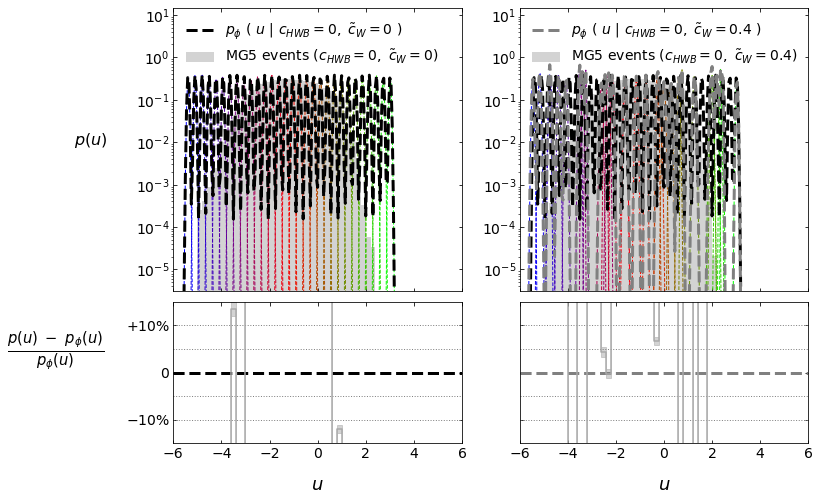

Evaluating losses  (attempt 1 / 100)
-  observable logL are [-446.56525218], combined is -446.56525218055555
-  eval completed in 180s
INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = 1000
INFO       DensityModel.fit              -  Training setting: validation_split = 0.3
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 4
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 2960561 samples, validate on 1268812 samples
Epoch 1/1000
2960561/2960561 [==============================] - 32s 11us/sample - loss: 2.6437e-05 - val_loss: 2.3164e-05
Epoch 2/1000
2960561/2960561 [==================

In [15]:
#  Load model if requested, otherwise build and fit
#

for white_meth in whitening_methods :
    #
    #  Load model if requested
    #
    if (type(white_meth.load_model_dir) != type(None)) and (os.path.exists(white_meth.load_model_dir)) and (load_models) :
        white_meth.density_model = DensityModel.from_dir(white_meth.load_model_dir)
    else :
        #
        #   Figure out the limits of the observables
        #
        all_data = np.concatenate([item[:,0] for c,item in white_meth.white_data.items()])
        min_dp, max_dp = np.min(all_data), np.max(all_data)
        white_observables_limits = [[1.05*min_dp - 0.05*max_dp, 1.05*max_dp - 0.05*min_dp]]
        #
        #   Create density model  
        #
        white_meth.density_model = DensityModel(name               = f"EWK_Zjj_density_model_{target_observable}", 
                                                num_gaussians      = num_gaussians                             , 
                                                num_conditions     = 2                                         , 
                                                num_observables    = 1                                         , 
                                                types              = [float]                                   ,
                                                observables_limits = white_observables_limits                  ,
                                                condition_limits   = [[np.min(cHWB_vals ), np.max(cHWB_vals )] ,
                                                                      [np.min(cWtil_vals), np.max(cWtil_vals)]],
                                                gauss_mean_scale   = 1./16.                                    ,
                                                gauss_frac_scale   = 1./16.                                    ,
                                                gauss_sigma_scale  = 1./16.                                    ) 
        plot_mixture_model(log=True)
        #
        #   Make sure initial state has no NaN/Inf loss
        #
        white_meth.density_model.ensure_valid_over_dataset (white_meth.white_data, white_meth.weights_to_fit_v2)
        #
        #   Fit density model
        #
        white_meth.density_model.fit(white_meth.white_data                                , 
                                     white_meth.weights_to_fit_v2                         ,
                                     max_epochs_per_observable = max_epochs               ,
                                     early_stopping_patience   = early_stopping_patience  ,
                                     early_stopping_min_delta  = early_stopping_min_delta ,
                                     validation_split          = validation_split         ,
                                     batch_size_per_observable = batch_size               )


In [16]:
#  Save model if requested

for white_meth in whitening_methods :
    if type(white_meth.save_model_dir) != type(None) :
        white_meth.density_model.save_to_dir(white_meth.save_model_dir)
        

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in true_divide


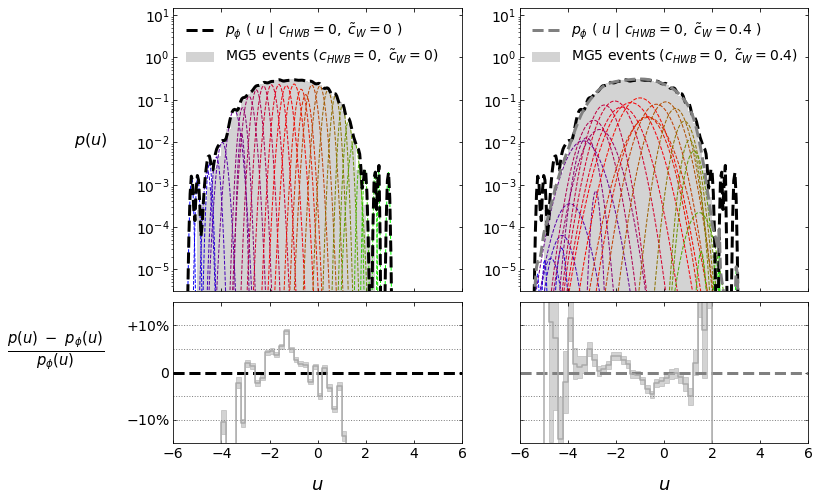

In [17]:
#  Plotting mixture of Gaussians, since it was observed that -ve deviations around SM are hard to model
#       if the distribution is dominated by a single Gaussian mode

plot_mixture_model(log=True)


In [18]:
#  Parse all pairs of wilson coefficients other than the origin
#

wilson_pairs = []
for cHWB in cHWB_vals :
    for cWtil in cWtil_vals :
        if (cHWB==0.) and (cWtil==0.) : continue
        wilson_pairs.append((cHWB, cWtil))
num_wilson_pairs = len(wilson_pairs)
print(f"{num_wilson_pairs} wilson pairs found")


24 wilson pairs found


In [19]:
#  Generate a large number of datapoints at 0.
#

n_gen = 1000000

print(f"Generating {n_gen} fake datapoints for [cHWB, cWtil] = [0, 0]")
start = time.time()
fake_white_datapoints_SM = white_meth.density_model.sample(n_gen, [0, 0])
end = time.time()
print(f"{n_gen} datapoints generated at (0, 0) in {int(end-start):.0f}s")

fake_white_datapoints = {}
for wilson_pair in wilson_pairs :
    start = time.time()
    fake_white_datapoints [wilson_pair] = white_meth.density_model.sample(n_gen, wilson_pair)
    end = time.time()
    print(f"{n_gen} datapoints evaluated at {wilson_pair} in {(end-start):.2f}s")
    

Generating 1000000 fake datapoints for [cHWB, cWtil] = [0, 0]
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints generated at (0, 0) in 11s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at (0.0, -0.4) in 11.54s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at (0.0, -0.2) in 11.30s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at (0.0, 0.2) in 11.40s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at (0.0, 0.4) in 11.48s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at (-4.0, 0.0) in 11.91s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/li

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/

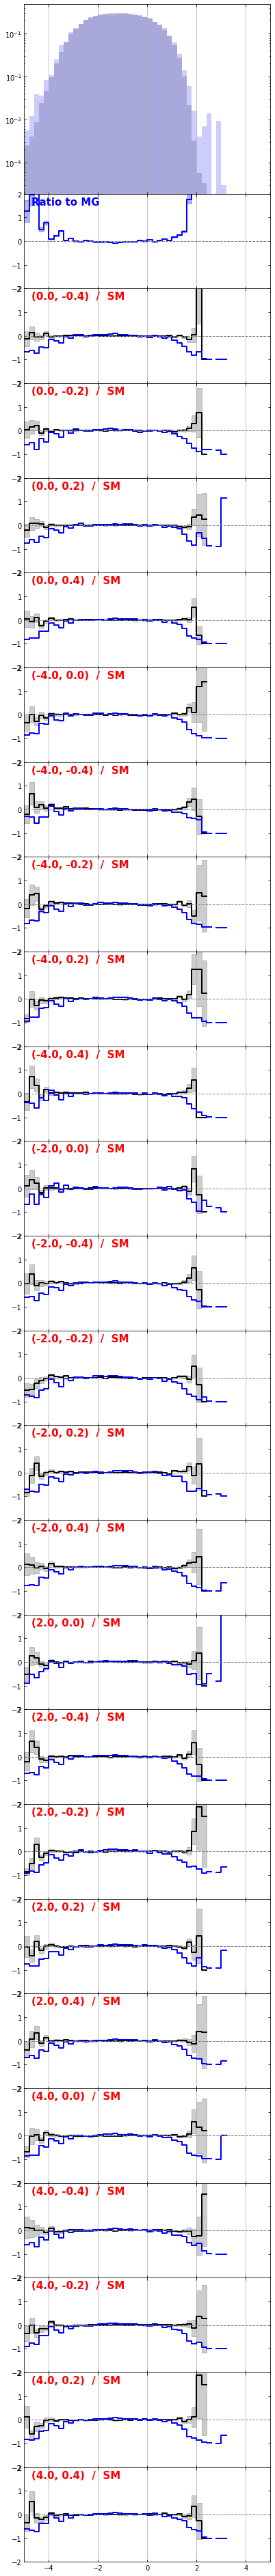

In [20]:

fig = plt.figure(figsize=(5, 2*(2+num_wilson_pairs)))

pad_height = 1. / (3+num_wilson_pairs)
lower      = 1. - 2*pad_height
ax = fig.add_axes([0, lower, 1, 2*pad_height])

bins = np.linspace(-5, 5, 51)
def get_histo (ds, weights=None) :
    if type(weights) == type(None) : weights = np.ones_like(ds)
    weights.reshape(ds.shape)
    bin_entries , _  = np.histogram(ds, weights=weights        , bins=bins)
    bin_variance, _  = np.histogram(ds, weights=weights*weights, bins=bins)
    frac_errors      = np.sqrt(bin_variance) / bin_entries
    return bin_entries / np.sum(weights), frac_errors

ds, weights                          = white_meth.white_data[(0,0)][:,0], white_meth.weights_to_fit_v2[(0,0)]
bin_entries, frac_errors             = get_histo(ds, weights)
bin_entries_model, frac_errors_model = get_histo(fake_white_datapoints_SM)
ax.hist(ds, weights=weights, density=True, color="darkgrey", alpha=0.5, bins=bins)
ax.hist(fake_white_datapoints_SM, density=True, color="blue", alpha=0.2, bins=bins)

ax.set_yscale("log")
ax.grid(which="both", axis="x")
ax.tick_params(which='both', axis="both", direction="in", right=True, top=True)
ax.set_xlim([-5, 5])

lower = lower - pad_height
ax    = fig.add_axes([0, lower, 1, pad_height]) 
ratio_to_MG       = bin_entries_model / bin_entries
ratio_to_MG_error = ratio_to_MG*np.sqrt(frac_errors*frac_errors + frac_errors_model*frac_errors_model)      
rat_x, rat_y, rat_ey = [], [], []
for idx, b in enumerate(bins) :
    rat_x.append(b)
    if (idx==0) or (idx==len(bins)-1) : continue
    rat_x.append(b)
for y, ey in zip(ratio_to_MG - 1, ratio_to_MG_error) :
    rat_y  .append(y  )
    rat_y  .append(y  )
    rat_ey .append(ey )
    rat_ey .append(ey )
rat_x, rat_y, rat_ey = np.array(rat_x), np.array(rat_y), np.array(rat_ey)
    
ax.plot(rat_x, rat_y, lw=2, color="b")
ax.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="b", alpha=0.3)
ax.axhline(0, ls="--", lw=1, c="grey")
ax.text(0.03, 0.97, "Ratio to MG", ha="left", va="top", transform=ax.transAxes, fontsize=15, color="b", weight="bold")
ax.grid(which="both", axis="x")
ax.tick_params(which='both', axis="both", direction="in", right=True, top=True)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])

for wilson_pair in wilson_pairs :
    lower = lower - pad_height
    ax = fig.add_axes([0, lower, 1, pad_height])
    
    ds, weights = white_meth.white_data[wilson_pair][:,0], white_meth.weights[wilson_pair]
    this_bin_entries, this_frac_errors = get_histo(ds, weights)
    ratio_to_SM       = this_bin_entries / bin_entries
    ratio_to_SM_error = ratio_to_SM*np.sqrt(frac_errors*frac_errors + this_frac_errors*this_frac_errors)
    
    #this_bin_entries_model, this_frac_errors_model = get_histo(fake_white_datapoints_SM, fake_datapoint_weights[wilson_pair])
    this_bin_entries_model, this_frac_errors_model = get_histo(fake_white_datapoints[wilson_pair])
    ratio_to_SM_model       = this_bin_entries_model / bin_entries_model
    ratio_to_SM_error_model = ratio_to_SM_model*np.sqrt(frac_errors_model*frac_errors_model + this_frac_errors_model*this_frac_errors_model)
    
    rat_x, rat_y, rat_ey, rat_ym, rat_eym = [], [], [], [], []
    for idx, b in enumerate(bins) :
        rat_x.append(b)
        if (idx==0) or (idx==len(bins)-1) : continue
        rat_x.append(b)
    for y, ey, ym, eym in zip(ratio_to_SM - 1, ratio_to_SM_error, ratio_to_SM_model - 1, ratio_to_SM_error_model) :
        rat_y  .append(y  )
        rat_y  .append(y  )
        rat_ey .append(ey )
        rat_ey .append(ey )
        rat_ym .append(ym )
        rat_ym .append(ym )
        rat_eym.append(eym)
        rat_eym.append(eym)
    rat_x, rat_y, rat_ey, rat_ym, rat_eym = np.array(rat_x), np.array(rat_y), np.array(rat_ey), np.array(rat_ym), np.array(rat_eym)
    
    ax.plot(rat_x, rat_y, lw=2, color="k")
    ax.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="k", alpha=0.2)
    ax.plot(rat_x, rat_ym, lw=2, color="b")
    ax.axhline(0, ls="--", lw=1, c="grey")
    ax.text(0.03, 0.97, f"{wilson_pair}  /  SM", ha="left", va="top", transform=ax.transAxes, fontsize=15, color="r", weight="bold")
    ax.grid(which="both", axis="x")
    ax.tick_params(which='both', axis="both", direction="in", right=True, top=True)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-2, 2])
        
plt.savefig(f"density_model_{target_observable}_2D.pdf", bbox_inches="tight")
plt.show()
